# Imports

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import display
import scipy.stats as sci_stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Directories

In [3]:
os.chdir("..")
print(os.getcwd())

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1


In [4]:
DATA_DIR = os.path.join(os.getcwd(), "data")
print(DATA_DIR)

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-1/data


# The data

In [5]:
file_name = "assignment1_dev_set.csv"

df = pd.read_csv(os.path.join(DATA_DIR, file_name), index_col=0)
cols = df.columns

In [6]:
display(cols)

Index(['Project ID', 'Experiment type', 'Sex', 'Host age', 'BMI',
       'Disease MESH ID', 'Acholeplasma axanthum',
       'Acidaminococcus fermentans', 'Acidaminococcus intestini',
       'Actinomyces lingnae',
       ...
       'Clostridium sphenoides', 'Clostridium spiroforme',
       'Clostridium stercorarium', 'Clostridium symbiosum',
       'Clostridium thermosuccinogenes', 'Clostridium xylanolyticum',
       'Eubacterium brachy', 'Eubacterium dolichum', 'Eubacterium sulci',
       'Ruminococcus gnavus'],
      dtype='object', length=140)

We can see that the `BMI` column is the 6<sup>th</sup> one and the bacterial concentrations start from the 8<sup>th</sup> column up to the last (141<sup>st</sup>)  
Also, since we want to classify `BMI` based **only** on the bacteria in the gut microbiome, we can **exclude** the following columns:
- `Project ID`
- `Experiment type`
- `Disease MESH ID`

Regarding the `Sex` and `Host age` columns, I decided to separate them in order to examine them one by one, and not with the bacterial data.

In [7]:
# drop columns Project ID, Experiment type, Sex, Host age, Disease MESH ID
cols_to_drop = [
    "Project ID",
    "Experiment type",
    "Sex",
    "Host age",
    "BMI",
    "Disease MESH ID"
]

bmi = df["BMI"]
sex = df["Sex"]
age = df["Host age"]
bacteria = df.drop(cols_to_drop, axis=1)

In [8]:
bacteria.head()

,Acholeplasma axanthum,Acidaminococcus fermentans,Acidaminococcus intestini,Actinomyces lingnae,Akkermansia muciniphila,Alistipes finegoldii,Alistipes indistinctus,Alistipes obesi,Alistipes onderdonkii,Alistipes putredinis,...,Clostridium sphenoides,Clostridium spiroforme,Clostridium stercorarium,Clostridium symbiosum,Clostridium thermosuccinogenes,Clostridium xylanolyticum,Eubacterium brachy,Eubacterium dolichum,Eubacterium sulci,Ruminococcus gnavus
0,0.000000,0.000000,0.000000,0.000000,0.017674,0.000000,0.00000,0.0,0.117827,0.005891,...,0.005891,0.029457,0.000000,0.000000,0.002946,0.000000,0.000000,0.000000,0.002946,0.100153
1,0.001028,0.000000,0.000000,0.000000,13.015800,0.001542,0.00000,0.0,0.073486,0.403916,...,0.000000,0.002569,0.412652,0.003083,0.000000,0.000000,0.008736,0.014903,0.077597,0.004625
2,0.001406,0.000000,0.000000,0.001406,0.002812,0.201074,0.00000,0.0,0.043590,0.105459,...,0.000000,0.005624,0.002812,0.007031,0.000000,0.000000,0.000000,0.000000,0.005624,0.016873
3,0.000000,0.008825,0.273562,0.000000,0.044123,0.004412,0.34857,0.0,0.026474,0.586834,...,0.017649,0.198553,0.000000,0.158842,0.030886,0.101483,0.000000,0.000000,0.000000,0.000000
4,0.002878,0.037419,7.359970,0.000000,0.872143,0.000000,0.00000,0.0,1.732770,1.004550,...,0.305106,0.135283,0.000000,0.051811,0.054689,0.083473,0.020148,0.000000,0.054689,0.011513


## General Statistics

### BMI

In [9]:
def plot_kde(
        df,
        title="Kernel Density Estimation",
        x_label="Values",
        y_label="Frequency",
        hue_by=None
    ):
    '''Plot Kernel Density Estimation of the given data.'''

    plt.figure(figsize=(10, 7))

    if isinstance(hue_by, pd.Series) or isinstance(hue_by, pd.DataFrame):
        data = pd.DataFrame({"BMI": df, "Color by": hue_by})
        ax = sns.histplot(
            data=data,
            x="BMI",
            bins=20,
            kde=True,
            hue="Color by",
            alpha=0.6
        )
        ax.get_legend().set_title("")
    else:
        sns.histplot(df, bins=20, kde=True)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

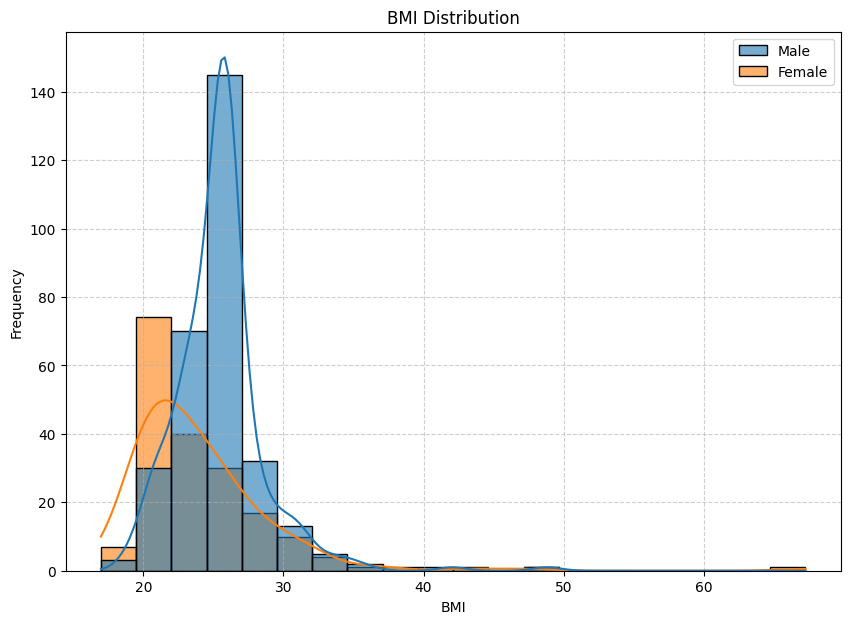

In [10]:
plot_kde(
    bmi,
    title="BMI Distribution",
    x_label="BMI",
    hue_by=sex
)

### Bacteria

In [11]:
def plot_feature_spans(
        data,
        sort_features=True,
        title="Features"
    ):
    '''Plot the min, max, and mean values of each feature in the dataframe.'''

    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    elif not isinstance(data, np.ndarray):
        raise ValueError("Input must be a pandas DataFrame or a numpy array.")

    stats = np.array([
        np.mean(data, axis=0),
        np.min(data, axis=0),
        np.max(data, axis=0)
    ]).T

    if sort_features:
        stats = stats[stats[:, 0].argsort()]

    feature_indices = list(range(len(stats)))

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=feature_indices, y=stats[:, 0], 
        mode='markers',
        marker=dict(color='black', size=12),
        zorder=3,
        name="Mean"
    ))
    
    for i in feature_indices:
        min_val = stats[i, 1]
        max_val = stats[i, 2]
        fig.add_trace(go.Scatter(
            x=[i, i],
            y=[min_val, max_val],
            mode='lines',
            line=dict(color='red', width=5, dash='solid'),
            showlegend=False,
            hoverinfo="none",
            name="Min to Max"
        ))

    fig.add_trace(go.Scatter(
        x=feature_indices, y=stats[:, 1], 
        mode='markers',
        marker=dict(color='red', size=10),
        name="Min"
    ))

    fig.add_trace(go.Scatter(
        x=feature_indices, y=stats[:, 2], 
        mode='markers',
        marker=dict(color='red', size=10),
        name="Max"
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Feature Index",
        yaxis_title="Values",
        template="plotly_white",
        hovermode="x unified",
        height=600,
    )

    fig.show()

In [12]:
plot_feature_spans(bacteria)

Lets normalize them and see what they look like

In [13]:
zscaler = StandardScaler()
mmscaler = MinMaxScaler()

bacteria_zscaled = zscaler.fit_transform(bacteria)
bacteria_mmscaled = mmscaler.fit_transform(bacteria)

In [14]:
plot_feature_spans(bacteria_zscaled, title="Z-Scaled Features")
plot_feature_spans(bacteria_mmscaled, title="MinMax Scaled Features")

### Sex and Age

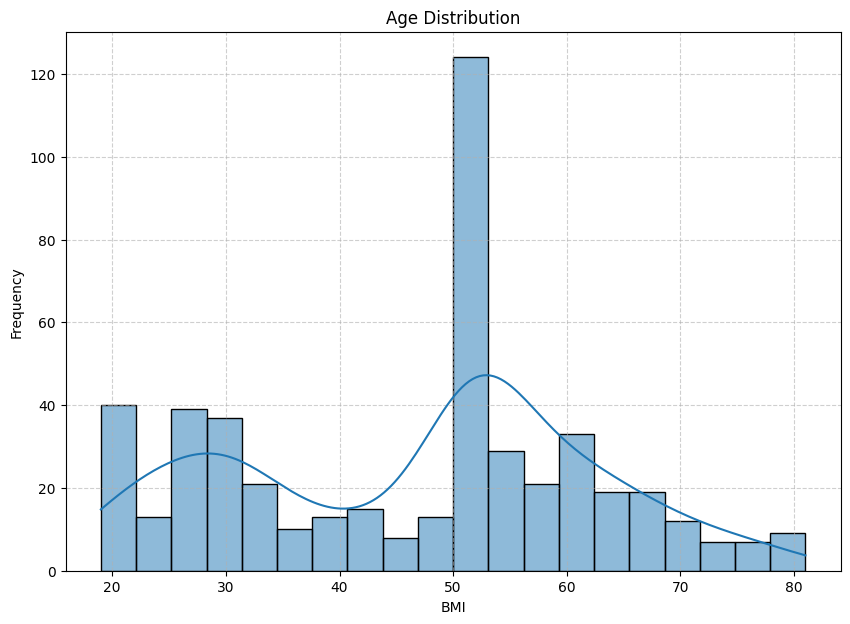

In [15]:
plot_kde(
    age,
    title="Age Distribution",
    x_label="BMI"
)

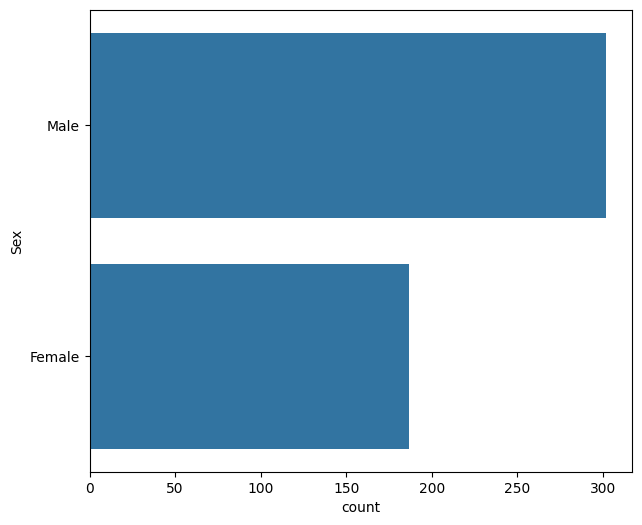

In [16]:
# Plot the number of males and females in the study
plt.figure(figsize=(7, 6))
sns.countplot(sex)
plt.show()

## Correlations

In [ ]:
def correlation_coefficients(
        df,
        against,
        show_plot=True,
        title="Correlation Coefficients"
    ):
    '''Calculate the correlation coefficients of the given dataframe against the
    given target data.

    The correlation coefficients are calculated using Pearson, Spearman, and Kendall
    methods. The correlation coefficients are then sorted based on the sum of the
    coefficients for each feature. The sorted features are then plotted using a
    scatter plot.
    '''

    corr_coeffs = np.zeros((df.shape[1], 3))

    for i, col in enumerate(df.columns):
        pearsons_corr = sci_stats.pearsonr(against, df[col])
        spearmans_corr = sci_stats.spearmanr(against, df[col])
        kendalls_corr = sci_stats.kendalltau(against, df[col])

        corr_coeffs[i, 0] = pearsons_corr[0]
        corr_coeffs[i, 1] = spearmans_corr[0]
        corr_coeffs[i, 2] = kendalls_corr[0]

    row_sums = np.sum(corr_coeffs, axis=1)
    sorted_row_indices = np.argsort(row_sums)
    corr_coeffs = corr_coeffs[sorted_row_indices]

    x = list(df.columns)
    sorted_cols = [x[i] for i in sorted_row_indices]

    if show_plot:
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=sorted_cols,
            y=corr_coeffs[:, 0],
            mode="markers",
            marker=dict(size=12),
            name="Pearson"
        ))

        fig.add_trace(go.Scatter(
            x=sorted_cols,
            y=corr_coeffs[:, 1],
            mode="markers",
            marker=dict(size=12),
            name="Spearman"
        ))

        fig.add_trace(go.Scatter(
            x=sorted_cols,
            y=corr_coeffs[:, 2],
            mode="markers",
            marker=dict(size=12),
            name="Kendall"
        ))

        fig.update_layout(
            title=title,
            xaxis_title="Features",
            yaxis_title="Correlation Coefficient",
            template="plotly_white",
            height=700
        )

        fig.show()

    return corr_coeffs, sorted_cols

In [ ]:
corr_array, sorted_bacteria = correlation_coefficients(
    bacteria,
    bmi
)